# Establishing human expert-level performance on classifying YNet yeast data.
   
   
The notebook will follow normal data-setup, normalization and batch-loading proceedures; 
however, classification will be done manually - within an interactive ipython widget. 

**Part 1: Loading and preparing the dataset - Yeast_v5**
  * 6 classes
  * 1300 images
            
**Part 2: Setting up an interactive ipython widget**
  * ipywidgets library allows interactive UI's in jupyter notebook

**Part 3: Manual image-by-image classification**


---

## Part 1: Data-loading

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path
import skimage.external.tifffile as tiff
from common import Statistics, dataset_source
from resources.conv_learner import *
from resources.plots import *
from IPython.display import clear_output

%matplotlib inline

In [3]:
PATH = "datasets/yeast_v5/"
data_path = Path(PATH)

In [4]:
CLASSES = ('WT', 'mfb1KO', 'mmr1KO', 'mmm1KO','mfb1KO_mmr1KO', 'num1KO' )
NUM_CLASSES = len(CLASSES)
BATCH_SIZE = 64
SIZE = 200

### Calculating normalization statistics

  * Calculated for each class separately 
  * Calculated over joint train and validation images

In [5]:
stats_name = "yeast_v5_per_class.dict"
classes = Statistics.source_class(data_path)

train_val = zip(classes['train'], classes['val'])
main_stats = Statistics.per_class(train_val, save_name=stats_name)

working on: datasets\yeast_v5\train\mfb1KO
working on: datasets\yeast_v5\val\mfb1KO
working on: datasets\yeast_v5\train\mfb1KO_mmr1KO
working on: datasets\yeast_v5\val\mfb1KO_mmr1KO
working on: datasets\yeast_v5\train\mmm1KO
working on: datasets\yeast_v5\val\mmm1KO
working on: datasets\yeast_v5\train\mmr1KO
working on: datasets\yeast_v5\val\mmr1KO
working on: datasets\yeast_v5\train\num1KO
working on: datasets\yeast_v5\val\num1KO
working on: datasets\yeast_v5\train\WT
working on: datasets\yeast_v5\val\WT


### Defining the dataset & applying transformations

  * Dataset is defined by Path with standard sub-folder structure. 
  * Normalization statistics are passed. 
  * Additional image augmentations can be applied.

In [6]:
def get_data(path: str, sz, bs):
    
    global lbl2index
    create, lbl2index, test_lbl2index = ImageClassifierData.prepare_from_path(path, val_name='val', bs=bs)
    
    # passing in normalization statistics dictionary mapped to indeces:
    main_stats_X = {lbl2index[key]: val for key, val in main_stats.items()}
    
    # defining additional image transformations (augmentations):
    tfms = tfms_from_stats(main_stats_X, sz, aug_tfms=[RandomDihedral()], crop_type=CropType.NO, pad=0)
    
    # printing out class-to-index mapping:
    print('\n class to index mapping:\n',lbl2index)
    
    return create(tfms)

In [7]:
data = get_data(PATH, SIZE, BATCH_SIZE)


 class to index mapping:
 {'WT': 0, 'mfb1KO': 1, 'mfb1KO_mmr1KO': 2, 'mmm1KO': 3, 'mmr1KO': 4, 'num1KO': 5}


---
#### Inspecting image augmentations:

In [8]:
augs = get_data(PATH, SIZE, 2)


 class to index mapping:
 {'WT': 0, 'mfb1KO': 1, 'mfb1KO_mmr1KO': 2, 'mmm1KO': 3, 'mmr1KO': 4, 'num1KO': 5}


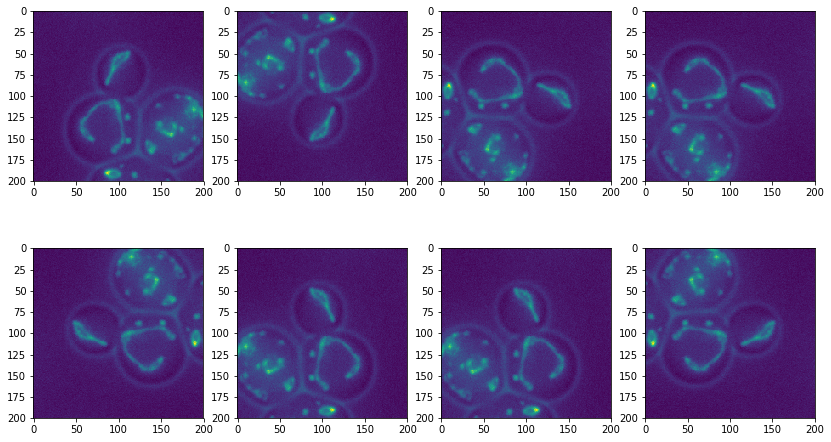

In [9]:
f = plt.figure(figsize=(14,8))
indx = 0

for i in range(8):
    x,y = next(iter(augs.aug_dl))
    xx = x[indx].cpu().numpy().copy()
    ims = np.stack(np.sum(xx, axis=0))
    f.add_subplot(2, 4, i +1)
    plt.imshow(ims)

---

---

## Part 2: Setting up an interactive classification widget:

  * Image batches loaded and normalized just as for real training pass.
  * Classification occurs manually. 
  * Results are stored and accuracy with respect to true labels is calculated

In [10]:
def on_button_clicked(pred):
    
    global idx
    global x
    global y
    global targs
    global preds
    global clss
    
    # converting to str and parsing to get description of the button clicked.
    _, cls, _ = str(pred).split("'")
    preds.append(lbl2index[cls])
    targs.append(y[idx])
    
    # re-creating the plot:
    clear_output()
    for c in clss:
        buttons = widgets.Button(description=c)
        buttons.on_click(on_button_clicked)
        display(buttons)
 
    if idx == (BATCH_SIZE - 1):
        print('new Batch!')
        idx = 0
        x, y = next(iter(data.trn_dl)) 
        xx = x[idx].cpu().numpy().copy()
        plt.imshow(np.sum(xx, axis=0))
        
    else:
        idx = idx + 1
        # loading it from GPU to CPU
        xx = x[idx].cpu().numpy().copy()
        yy = y[idx]
        plt.imshow(np.sum(xx, axis=0))
        
    evaluate(preds, targs)

In [11]:
def evaluate(a, b):
    print(f"human-level accuracy: [{sum((np.asarray(preds)) == (np.asarray(targs))) / len(preds):4.4}]") 

In [12]:
def manual_preds(loaded_preds = None, loaded_targs = None):    
    
    
    global idx
    global preds
    global targs
    global clss
    
    
    if loaded_preds is not None and loaded_targs is not None:
        preds = loaded_preds
        targs = loaded_targs
        print("Previousl results loaded!")
        print(evaluate(preds, targs))
        print("Continuing with new batch")
    else:
        preds = []
        targs = []
        print("no previous results loaded - fresh start")
        
    idx = 0
    clss = list(lbl2index.keys())
#     clss.append('Exit')

    # creating buttons
    for c in clss:
        buttons = widgets.Button(description=c)
        buttons.on_click(on_button_clicked)
        display(buttons)
    
    # load first image:
    xx = x[idx].cpu().numpy().copy()
    yy = y[idx]
    plt.imshow(np.sum(xx, axis=0))

---

## Part 3: Manual classification:


In [13]:
x, y = next(iter(data.trn_dl))

no previous results loaded - fresh start


Button(description='WT', style=ButtonStyle())

Button(description='mfb1KO', style=ButtonStyle())

Button(description='mfb1KO_mmr1KO', style=ButtonStyle())

Button(description='mmm1KO', style=ButtonStyle())

Button(description='mmr1KO', style=ButtonStyle())

Button(description='num1KO', style=ButtonStyle())

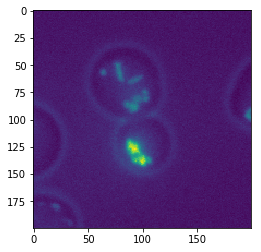

In [14]:
# calling manual_preds to start interactive classification:

manual_preds()    


In [ ]:
print(lbl2index)
print(preds[0:10])
print(targs[0:10])

In [ ]:
evaluate(preds, targs)

### Storing and loading results:

In [ ]:
# storing results:
man_preds = [preds, targs]
save_preds(man_preds)

In [ ]:
preds_loaded, targs_loaded = load_preds('man_preds_v5_1')
print(preds_loaded[0:10])
print(targs_loaded[0:10])

In [ ]:
# continuing from previous session:

preds_loaded, targs_loaded = load_preds('man_preds_v5_1')
manual_preds(loaded_preds = preds_loaded, loaded_targs = targs_loaded)

In [ ]:
evaluate(preds, targs)

In [ ]:
# dumping to pickle file
import pickle

def save_preds(man_preds_to_save, name="man_preds_v5_1") -> None:
    with open(name, 'wb') as file:
        pickle.dump(man_preds_to_save, file)
    print(f"predictions saved to: {name}")

    
def load_preds(name="man_preds_v5_1"):
    with open(name, 'rb') as file:
        preds_loaded, targs_laoded = pickle.load(file)
        
    print(f"predictions loaded from: {name}")
    return(preds_loaded, targs_laoded)